In [20]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

from criminisi import load_measurements
from utils import imshow, select_lines, draw_lines

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Testing out how well this works

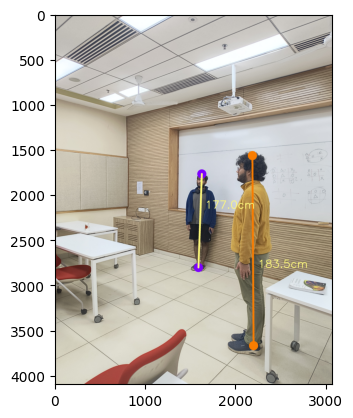

In [115]:
name = "kartripta12"

img = cv.imread(f"data/{name}.jpg")
depth = np.load("depthpro_out/depths.npz")[name]
known_lines, lengths = load_measurements(name)

drawn_heights = draw_lines(img, known_lines, lengths)

cv.imwrite(f"visuals/actual_heights_{name}.png", drawn_heights)
imshow(drawn_heights)

In [116]:
known_lines[0]

array([[2194.07836247, 3671.84617042],
       [2181.36495755, 1567.77765597]])

In [117]:
lines = select_lines(img, 2).astype(np.uint64)

In [118]:
lines[0], lines[1]

(array([[2189, 3705],
        [2156, 1666]], dtype=uint64),
 array([[1613, 2796],
        [1613, 1832]], dtype=uint64))

In [119]:
import open3d as o3d

H, W = img.shape[:-1]
K = np.load("r-calibration.npz")["K"]

f_x = K[0, 0]
f_y = K[1, 1]
c_x = K[0, 2]
c_y = K[1, 2]
intrinsics = o3d.camera.PinholeCameraIntrinsic(W, H, f_x, f_y, c_x, c_y)

In [120]:
def backproject(depth, x, y):
	x_3d = (x - c_x) * depth / f_x
	y_3d = (y - c_y) * depth / f_y

	return np.array([x_3d, y_3d, depth])

In [ ]:
meas = []

for line in lines:
	pt_a = line[0]
	pt_b = line[1]

	depth_a = depth[pt_a[1], pt_a[0]]
	depth_b = depth[pt_b[1], pt_b[0]]

	pt3d_a = backproject(depth_a, pt_a[0], pt_a[1])
	pt3d_b = backproject(depth_b, pt_b[0], pt_b[1])

	dist = np.linalg.norm(pt3d_a - pt3d_b) * 100

	meas.append(dist)

In [122]:
meas

[179.86733557108715, 173.018156603356]

In [123]:
meas[0] / lengths[0], meas[1] / lengths[1]

(0.9802034636026548, 0.9775037096234802)

In [124]:
measurements = [round(x, 2) for x in meas]

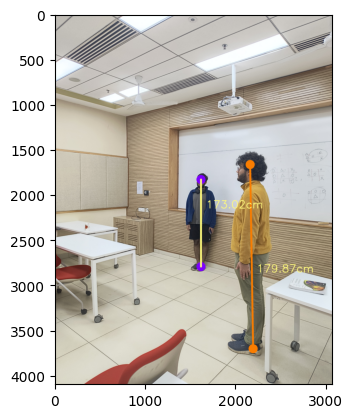

In [125]:
measured_heights = draw_lines(img, lines, measurements)
imshow(measured_heights)

In [126]:
cv.imwrite(f"visuals/measured_heights_{name}_dp.jpg", measured_heights)

True

### Point Cloud 

In [127]:
color = o3d.geometry.Image(cv.cvtColor(img, cv.COLOR_BGR2RGB))
depth_o3d = o3d.geometry.Image(depth)

rgbd = o3d.geometry.RGBDImage.create_from_color_and_depth(color, depth_o3d, convert_rgb_to_intensity=False)

In [128]:
cloud = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd, intrinsics)

In [129]:
cloud.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]])
cloud

PointCloud with 12582912 points.

In [130]:
vis = o3d.visualization.Visualizer()

vis.create_window("the cloud", width = 1080, height = 1080)
vis.add_geometry(cloud)
vis.run()
vis.destroy_window()
